In [9]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# 資料路徑
DATASET_PATH  = r'C:\Users\user\程式碼_明昌瑕疵檢測\影像辨識\Machan Dataset'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 2

# 凍結網路層數
FREEZE_LAYERS = -26

# Epoch 數
NUM_EPOCHS = 10

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
#for cls, idx in train_batches.class_indices.items():
#    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
#for layer in net_final.layers[:FREEZE_LAYERS]:
#    layer.trainable = False
#for layer in net_final.layers[FREEZE_LAYERS:]:
#    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
history = net_final.fit_generator(train_batches,
                                steps_per_epoch = train_batches.samples // BATCH_SIZE,
                                validation_data = valid_batches,
                                validation_steps = valid_batches.samples // BATCH_SIZE,
                                epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Found 1920 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


C:\Users\user\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Epoch 1/10
960/960 [==============================] - 150s 156ms/step - loss: 0.3817 - acc: 0.9266 - val_loss: 4.3653e-04 - val_acc: 1.0000
Epoch 2/10
960/960 [==============================] - 133s 139ms/step - loss: 0.2728 - acc: 0.9630 - val_loss: 0.4305 - val_acc: 0.7453
Epoch 3/10
960/960 [==============================] - 134s 139ms/step - loss: 0.6048 - acc: 0.9365 - val_loss: 0.0471 - val_acc: 0.9984
Epoch 4/10
960/960 [==============================] - 134s 139ms/step - loss: 0.4978 - acc: 0.9526 - val_loss: 1.6586 - val_acc: 0.8609
Epoch 5/10
960/960 [==============================] - 132s 138ms/step - loss: 0.1591 - acc: 0.9807 - val_loss: 0.0404 - val_acc: 1.0000
Epoch 6/10
960/960 [==============================] - 133s 138ms/step - loss: 0.3307 - acc: 0.9573 - val_loss: 0.0582 - val_acc: 0.9937
Epoch 7/10
960/960 [==============================] - 133s 139ms/step - loss: 0.1549 - acc: 0.9812 - val_loss: 0.7547 - val_acc: 0.9219
Epoch 8/10
960/960 [========================

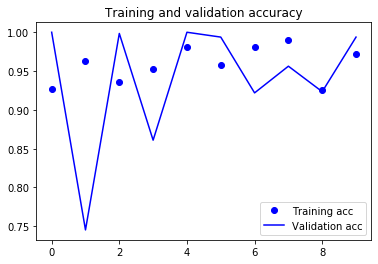

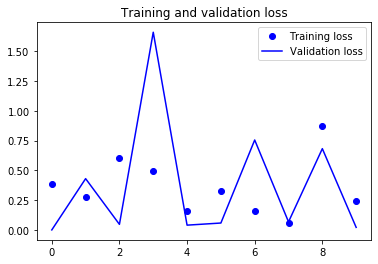

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        DATASET_PATH + '/test',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

test_loss, test_acc = net_final.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)

Found 640 images belonging to 2 classes.
test acc: 0.9


In [4]:
#將這段 Python 程式碼儲存為 predict_resnet50.py，然後就可以拿來辨識圖片了。我們可以直接使用 Kaggle 所提供的圖片進行測試：
# 辨識狗與貓
#python3 predict_resnet50.py train/dog.1000[0-2].jpg train/cat.1000[0-2].jpg